# Testing MPO

In [2]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make oracles.

In [8]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 11
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, DGLOracle, RDKitOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'balanced',
    'scoring': 'vina',
    'seed': 5,
    **config_
}

docking_oracle = DockingOracle(
    'CASP3 affinity',
    receptor_path=f'{path}/dockstring_targets/CASP3_target.pdbqt',
    config=config
)
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')

# create evaluators
docking_cost_function = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8, 9.5),
    acceptable=(7.7, 9.5)
)

log_P_cost_function = ClassicUtilityFunction(
    log_P_oracle,
    ideal=(0.5, 2),
    acceptable=(-0.5, 3.5)
)

log_S_cost_function = ClassicUtilityFunction(
    log_S_oracle,
    ideal=(-2, 1),
    acceptable=(-4, 1)
)

assays = [docking_oracle, log_P_oracle, log_S_oracle]
cost_functions = [docking_cost_function, log_P_cost_function, log_S_cost_function]

Instantiate designer.

In [9]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [170]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

Prepare MPO ranking function.

In [172]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def rank_molecules(costs):

    # Multi-dimensional non-dominated fusion sort
    nds, nds_ranks = NonDominatedSorting().do(
        costs, return_rank=True, only_non_dominated_front=False)
    penalty_sums = np.sum(costs, axis=1)
    fused_ranks = np.lexsort([penalty_sums, nds_ranks]) # prioritizes last column
    
    return fused_ranks.tolist()

Multi-step selection.

In [173]:
import numpy as np
from tqdm.notebook import tqdm

for molecule in library:
    molecule.update_annotations(
        {'timestep': 0, **{a.name: a(molecule) for a in assays}})

costs = np.asarray([cost(library) for cost in cost_functions[:2]]).T
ranking = rank_molecules(costs)
best = ranking

print([cost(library[best]) for cost in cost_functions])
print(best)

for step in tqdm(range(1, 30)):
    
    analogs = []
    for b in best:
        if step % 3 == 2:
            analogs += designer.design(
                library[b], 8, strategy='grow')
        else:
            analogs += designer.design(
                library[b], 8, strategy='replace', temperature=1.0)

    # Get costs
    library += analogs
    
    if step < 8:
        costs = np.asarray([cost(library) for cost in cost_functions[:2]]).T
    else:
        costs = np.asarray([cost(library) for cost in cost_functions]).T

    ranking = rank_molecules(costs)
    best = ranking[:5]
    # best = np.random.choice(len(costs))

    for analog in analogs:
        analog.update_annotations(
            {'timestep': step, **{a.name: a(analog) for a in assays}})

    print(step, costs[best])
    print(step, best)

[array([12.28432502, 14.09592146, 15.51626031, 16.4495505 , 22.41324016]), array([0.75054667, 0.        , 0.        , 0.        , 0.        ]), array([0.70063162, 0.10000098, 0.        , 0.        , 0.        ])]
[2, 4, 3, 0, 1]


  0%|          | 0/29 [00:00<?, ?it/s]

1 [[ 8.47055475  0.29486667]
 [ 7.99902902  2.55616144]
 [11.1728942   0.0128    ]
 [11.39005611  0.        ]
 [ 6.61744749  4.910656  ]]
1 [25, 29, 33, 32, 18]
2 [[5.69846682 0.48726667]
 [7.2474007  0.18353333]
 [8.062601   0.        ]
 [5.43473841 5.27483089]
 [4.99450436 6.25450081]]
2 [58, 50, 74, 81, 78]
3 [[ 5.23713768  0.        ]
 [ 4.37257952  2.05520896]
 [ 4.03030613  3.45142084]
 [ 3.2418348  16.654561  ]
 [ 5.8422989   0.        ]]
3 [111, 91, 124, 118, 115]
4 [[1.73661282 0.00826667]
 [4.43642355 0.        ]
 [4.65124189 0.5492    ]
 [5.23713768 0.        ]
 [4.37257952 2.05520896]]
4 [139, 133, 153, 111, 91]
5 [[1.73661282 0.00826667]
 [4.43642355 0.        ]
 [3.42304601 0.52233333]
 [4.07356729 0.1772    ]
 [4.59698179 0.        ]]
5 [139, 133, 184, 194, 175]
6 [[1.73661282 0.00826667]
 [3.36893937 0.        ]
 [2.89581621 0.56546667]
 [3.29147295 0.23902667]
 [4.07356729 0.1772    ]]
6 [139, 217, 212, 210, 194]
7 [[1.73661282 0.00826667]
 [3.36893937 0.        ]
 [2.

# Visualizing results

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Text(0.5, 1.0, 'Heavy atom count vs. pIC50')

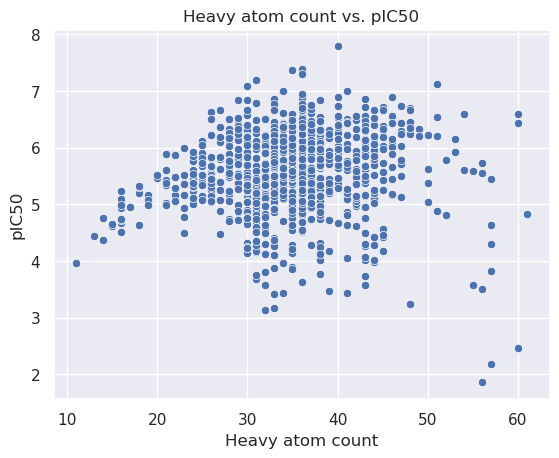

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Descriptors import HeavyAtomCount

sns.set()
sns.scatterplot(
    x=[HeavyAtomCount(m.mol) for m in library],
    y=docking_oracle(library),
)

plt.xlabel('Heavy atom count')
plt.ylabel('pIC50')
plt.title('Heavy atom count vs. pIC50')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

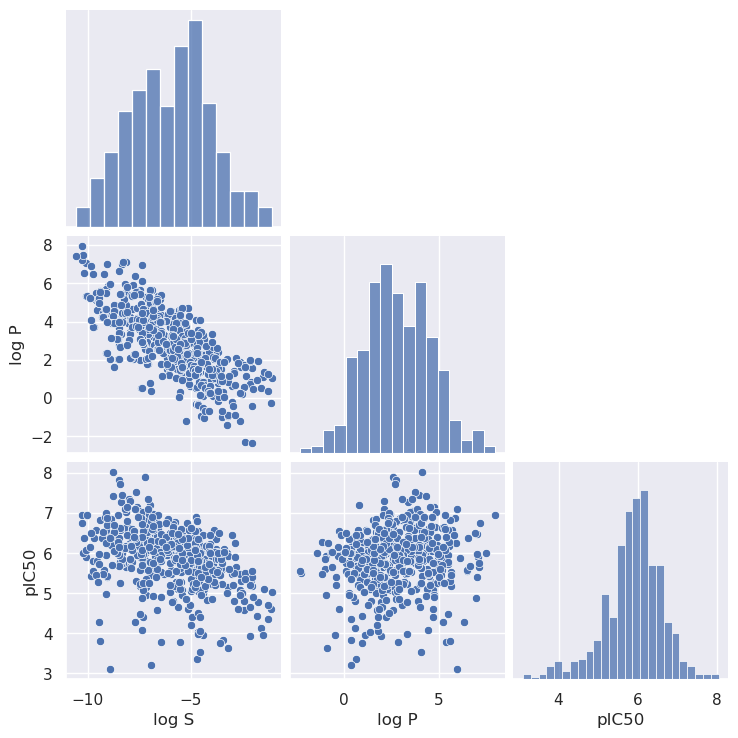

In [14]:
import pandas as pd

sns.pairplot(
    pd.DataFrame([{'log S': log_S_oracle(l)[0],
                   'log P': log_P_oracle(l)[0],
                   'pIC50': docking_oracle(l)[0]} for l in library]),
    corner=True
)

## Visualizing the best across rounds

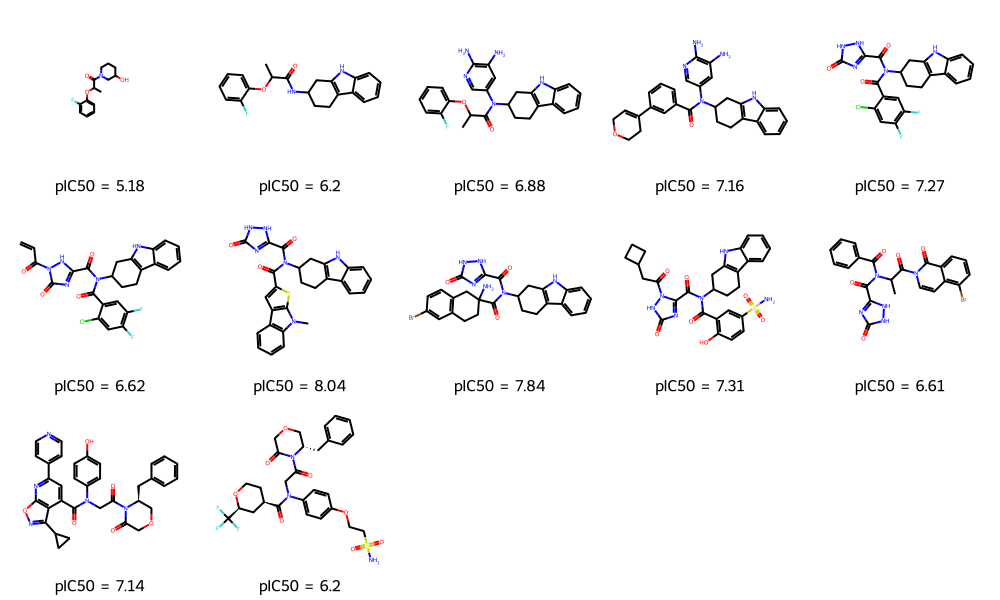

In [15]:
best_across_round = [
    library.annotations.query(f'timestep == {i}')['CASP3 affinity']
    .sort_values(na_position='first')
    .index[-1].item()
    for i in range(int(library.annotations.timestep.max()))
    if library.annotations.query(f'timestep == {i}')['CASP3 affinity'].any()
]

from rdkit.Chem.Draw import MolsToGridImage

get_affinity = lambda idx: library[idx]['CASP3 affinity'][0]
MolsToGridImage(
    [m.mol for m in library[best_across_round]],
    molsPerRow=5,
    legends=[f'pIC50 = {round(get_affinity(b), 2)}' for b in best_across_round]
)

In [276]:
designer.design(library[2], )

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/scipy/sparse/_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  


OrderedSet({<dgym.molecule.Molecule object at 0x7efc14f1db50>})

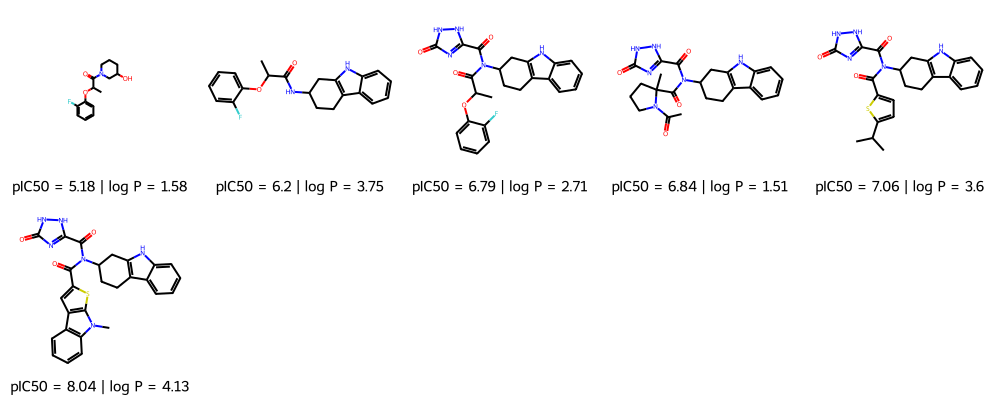

In [16]:
mol = library[np.nanargmax(docking_oracle(library)).item()]
milestones = [mol]
while mol.inspiration:
    milestones.append(mol.inspiration)
    mol = mol.inspiration
    
milestones = list(reversed(milestones))

MolsToGridImage(
    [m.mol for m in milestones],
    molsPerRow=5,
    legends=[f'pIC50 = {round(docking_oracle(m)[0], 2)} | log P = {round(log_P_oracle(m)[0], 2)}' for m in milestones]
)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

Text(0.5, 1.0, 'New compounds synthesized each round')

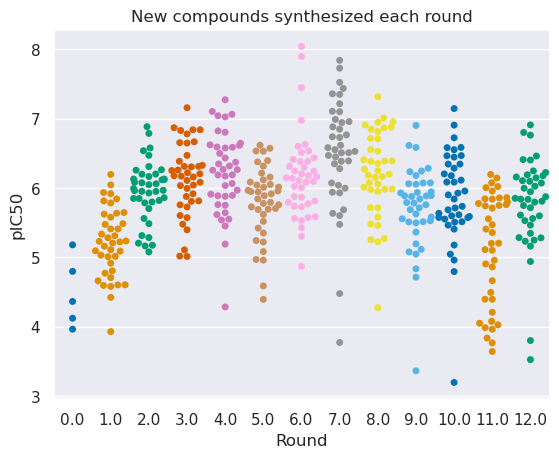

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

objective = 'CASP3 affinity'
annotations = library.annotations.iloc[:-40]
annotations[objective] = [l[0] for l in annotations[objective]]

sns.swarmplot(
    annotations,
    x='timestep',
    y=objective,
    hue='timestep',
    palette='colorblind',
    # complementary=True,
    legend=False
)

plt.ylabel('pIC50')
plt.xlabel('Round')
plt.title('New compounds synthesized each round')

In [27]:
max_timestep = int(library.annotations.timestep.max())

records = []
for timestep, group in library.annotations.groupby('timestep'):
    for _, mol in group.iterrows():
        record = {'pIC50': mol['CASP3 affinity'][0], 'timestep': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'timestep': t})

df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

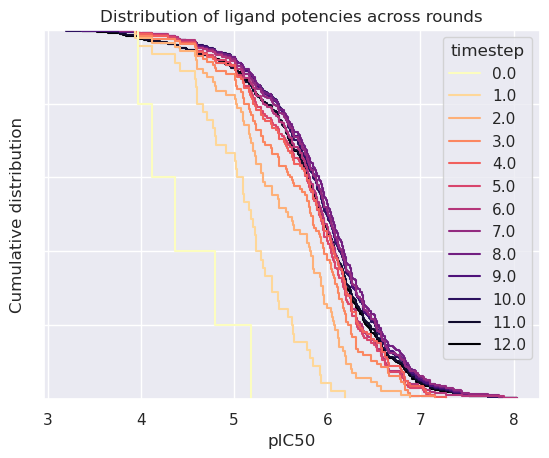

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

g = sns.ecdfplot(
    df,
    x='pIC50',
    hue='timestep',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

Text(0.5, 1.0, 'pIC50 vs ring count and log P across single selection run')

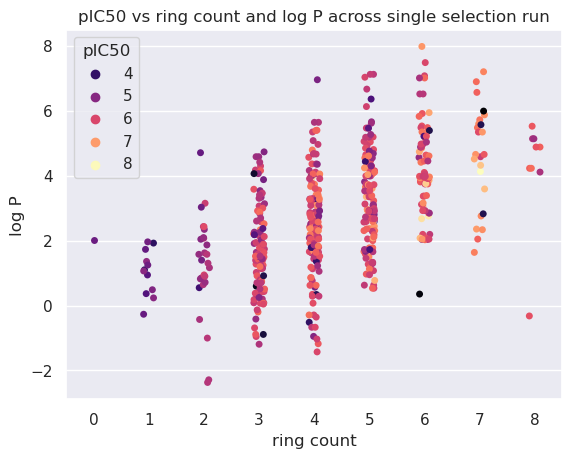

In [61]:
from rdkit.Chem.Descriptors import RingCount, MolLogP

admet = pd.DataFrame({
    'ring count': RDKitOracle('RingCount')(library),
    'log P': log_P_oracle(library),
    'log S': log_S_oracle(library),
    'pIC50': docking_oracle(library)
})

sns.stripplot(
    admet,
    x = 'ring count',
    y = 'log P',
    hue = 'pIC50',
    palette='magma'
)

plt.title('pIC50 vs ring count and log P across single selection run')

In [30]:
library.annotations.sort_values(by='CASP3 affinity', ascending=False)

,HBA,TPSA,RotBonds,reagsmi1,reagsmi2,reag1,Catalog ID,MW,MW (desalted),ClogP,...,reaction,RDB type,smiles,design_cycle,reactants,timestep,CASP3 affinity,MolLogP,GCN_canonical_ESOL,inspiration
232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Cn1c2ccccc2c2cc(C(=O)N(C(=O)c3nc(=O)[nH][nH]3)...,5.0,[Cn1c2ccccc2c2cc(C(=O)NC3CCc4c([nH]c5ccccc45)C...,6.0,[8.039562562637489],[4.125800000000003],[-8.781947135925293],CC(C)c1ccc(C(=O)N(C(=O)c2nc(=O)[nH][nH]2)C2CCc...
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Cc1cc(O)c(C(=O)N(C(=O)c2nc(=O)[nH][nH]2)C2CCc3...,5.0,[Cc1cc(O)c(C(=O)NC2CCc3c([nH]c4ccccc34)C2)cc1F...,6.0,[7.896076392135213],[2.57252],[-7.214517593383789],O=C(c1nc(=O)[nH][nH]1)N(C(=O)c1cc(F)c(F)cc1Cl)...
269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NC1(C(=O)N(C(=O)c2nc(=O)[nH][nH]2)C2CCc3c([nH]...,4.0,[NC1(C(=O)NC2CCc3c([nH]c4ccccc34)C2)CCc2cc(Br)...,7.0,[7.839453675665033],[2.754500000000002],[-8.490267753601074],CC(=O)N1CCCC1(C)C(=O)N(C(=O)c1nc(=O)[nH][nH]1)...
272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,O=C(NC1(C(=O)NC2CCc3c([nH]c4ccccc34)C2)CCc2cc(...,4.0,[NC1(C(=O)NC2CCc3c([nH]c4ccccc34)C2)CCc2cc(Br)...,7.0,[7.726563763931086],[2.673000000000001],[-8.429265022277832],CC(=O)N1CCCC1(C)C(=O)N(C(=O)c1nc(=O)[nH][nH]1)...
258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Cn1cccc1-c1csc(N(C(=O)c2nc(=O)[nH][nH]2)C(=O)c...,6.0,[Cn1cccc1-c1csc(NC(=O)c2cc3c4ccccc4n(C)c3s2)n1...,7.0,[7.522215181039105],[3.7536000000000023],[-7.653012752532959],Cn1c2ccccc2c2cc(C(=O)N(C(=O)c3nc(=O)[nH][nH]3)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
num_fronts = 10
utility_fns = ['log S', 'log P', 'pIC50']

records = []
records_merged = []
for idx, mol in enumerate(nds[:num_fronts]):
    score = scores[jdx]
    for adx, value in enumerate(score):
        records_merged.append({
            'property value (pIC50, logS, logP)': value,
            'assay': cost_functions[adx],
            'front': idx,
        })

    record = {name: value for (name, value) in zip(utility_fns, score)}
    record.update({'front': idx})
    records.append(record)

df = pd.DataFrame(records)
df_merged = pd.DataFrame(records_merged)

plt.fill_betweenx(log_S_utility_function.ideal, -1, num_fronts, alpha=0.2, zorder=-10)
plt.fill_betweenx(log_P_utility_function.ideal, -1, num_fronts, alpha=0.2, zorder=-10)
plt.fill_betweenx(docking_utility_function.ideal, -1, num_fronts, alpha=0.2, zorder=-10)

g = sns.stripplot(
    df_merged,
    x='front',
    y='property value (pIC50, logS, logP)',
    hue='assay',
)

# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# g.set_ybound(-6, 10)

plt.title('Non-dominated sorting fronts with a multi-objective function')

NameError: name 'nds' is not defined

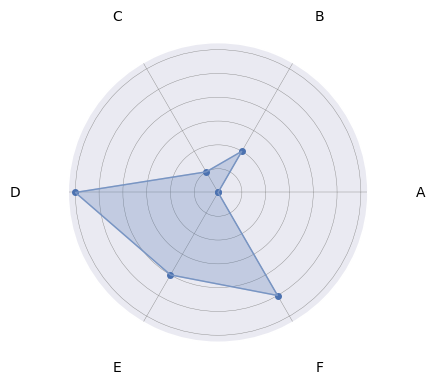

In [23]:
import matplotlib.pyplot as plt

from radar import radar_chart

labels = ["A", "B", "C", "D", "E", "F"]
values = [0, 2, 1, 6, 4, 5]

radar_chart(labels=labels, values=values)
plt.show()

In [37]:
library.annotations

TypeError: create_block_manager_from_column_arrays() got an unexpected keyword argument 'refs'

In [36]:
from pycirclize import Circos
import pandas as pd

# # Create RPG jobs parameter dataframe (3 jobs, 7 parameters)
# df = pd.DataFrame(
#     data=[
#         [80, 80, 80, 80, 80, 80, 80],
#         [90, 20, 95, 95, 30, 30, 80],
#         [60, 90, 20, 20, 100, 90, 50],
#     ],
#     index=["Hero", "Warrior", "Wizard"],
#     columns=["HP", "MP", "ATK", "DEF", "SP.ATK", "SP.DEF", "SPD"],
# )

# Initialize Circos instance for radar chart plot
circos = Circos.radar_chart(
    library.annotations,
    vmax=100,
    marker_size=6,
    grid_interval_ratio=0.2,
)

# # Plot figure & set legend on upper right
# fig = circos.plotfig()
# _ = circos.ax.legend(loc="upper right", fontsize=10)

TypeError: create_block_manager_from_column_arrays() got an unexpected keyword argument 'refs'